In [3]:
!source venv/bin/activate

# Standard imports for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

zsh:source:1: no such file or directory: venv/bin/activate


#Loading dataset

Datasets are almost the same, years diffears.  

We can charge all of them with a loop in our data/  
And print their sizes.

In [4]:
# charge datas for all years
years = range(2018, 2024)  # 2018 to 2023
df_fd = {}
df_varmod = {}

for year in years:
    try:
        df_fd[year] = pd.read_csv(f'../data/{year}/fd.csv', delimiter=";", encoding="utf-8")
        df_varmod[year] = pd.read_csv(f'../data/{year}/varmod.csv', delimiter=";", encoding="utf-8")
        print(f"Données de {year} chargées avec succès - fd: {df_fd[year].shape}, varmod: {df_varmod[year].shape}")
    except Exception as e:
        print(f"Erreur lors du chargement des données de {year}: {e}")

Données de 2018 chargées avec succès - fd: (424571, 124), varmod: (1878, 6)
Données de 2019 chargées avec succès - fd: (416298, 124), varmod: (1877, 6)
Données de 2020 chargées avec succès - fd: (319398, 124), varmod: (1877, 6)
Données de 2021 chargées avec succès - fd: (343304, 73), varmod: (1202, 6)
Données de 2022 chargées avec succès - fd: (348964, 73), varmod: (1199, 6)
Données de 2023 chargées avec succès - fd: (348624, 83), varmod: (1593, 6)


#Explore data

###Sample of 2023 dataset

In [5]:
# analyze varmod file : variables descriptions
sample_varmod = df_varmod[2023] if 2023 in df_varmod else next(iter(df_varmod.values()))
print("Structure du fichier varmod (dictionnaire des variables):")
print(sample_varmod.head())

Structure du fichier varmod (dictionnaire des variables):
      COD_VAR                                            LIB_VAR COD_MOD  \
0         AAC  Exercice d'une activité professionnelle réguli...       1   
1         AAC  Exercice d'une activité professionnelle réguli...       2   
2         AAC  Exercice d'une activité professionnelle réguli...       9   
3         AAC  Exercice d'une activité professionnelle réguli...     NaN   
4  ACL_EMPLOI  Classe d'emploi (emploi actuel ou dernier emploi)      I1   

                                  LIB_MOD TYPE_VAR  LONG_VAR  
0                                     Oui     CHAR       1.0  
1                                     Non     CHAR       1.0  
2                             Non réponse     CHAR       1.0  
3                              Hors champ     CHAR       1.0  
4  Emploi indépendant de niveau supérieur     CHAR       3.0  


###Compare new/old columns between years

Goal is to detect some data changes between years, like new/old columns or datas

In [6]:
# verify consistency of columns between years
all_years_fd_cols = {}
all_years_varmod_cols = {}

for year in df_fd:
    all_years_fd_cols[year] = set(df_fd[year].columns)
    all_years_varmod_cols[year] = set(df_varmod[year].columns)

# find common columns
common_fd_cols = set.intersection(*all_years_fd_cols.values()) if all_years_fd_cols else set()
common_varmod_cols = set.intersection(*all_years_varmod_cols.values()) if all_years_varmod_cols else set()

print(f"Nombre de colonnes communes dans fd à travers toutes les années: {len(common_fd_cols)}")
print(f"Nombre de colonnes communes dans varmod à travers toutes les années: {len(common_varmod_cols)}")

# identify columns that appear or disappear according to the years
for year in sorted(df_fd.keys()):
    if year == min(df_fd.keys()):
        continue
    prev_year = year - 1
    if prev_year in df_fd:
        new_cols = all_years_fd_cols[year] - all_years_fd_cols[prev_year]
        removed_cols = all_years_fd_cols[prev_year] - all_years_fd_cols[year]
        
        if new_cols:
            print(f"Nouvelles colonnes dans fd {year} par rapport à {prev_year}: {new_cols}")
        if removed_cols:
            print(f"Colonnes supprimées dans fd {year} par rapport à {prev_year}: {removed_cols}")

Nombre de colonnes communes dans fd à travers toutes les années: 33
Nombre de colonnes communes dans varmod à travers toutes les années: 6
Nouvelles colonnes dans fd 2021 par rapport à 2020: {'PCS2', 'RAISNDISPONE', 'AGE6', 'RECNE', 'HEFFEMP', 'STCOMM2020', 'SALTYP', 'MRJNE', 'IDENT', 'MRBNE', 'RAISNSOUNE', 'MRHNE', 'SOUSEMPLR', 'ISCO2', 'DISPONE', 'HEFFTOT', 'NAFANTG088N', 'PCS1', 'MRFNE', 'COUPL_LOG', 'SOU_C', 'STATUTDET', 'DEMNE', 'ANCSSEMP', 'NOI', 'MRINE', 'HHABEMP', 'MRDNE', 'TYPLOG5', 'MRCNE', 'MRENE', 'PCS1Q', 'RAISNRECNE', 'ANCEMPL4', 'MRANE', 'HHABTOT', 'MRGNE', 'DIP7', 'CL_EMPLOI', 'RAISDISPPLC'}
Colonnes supprimées dans fd 2021 par rapport à 2020: {'OFFRE', 'MRF', 'HPLUSA', 'QPRC', 'HHC6', 'JOURTR', 'CSA', 'SITANT', 'MRS', 'RDET', 'PASTRF', 'HREC', 'MRE', 'NBTOTE', 'SOUB', 'CSTOTPRM', 'NONDIC', 'AGE3', 'MRDBIS', 'CONTACT', 'COURED', 'NAFANT', 'DUHAB', 'MRH', 'NFRRED', 'STMN', 'CREACCP', 'STATOEP', 'MRD', 'MRK', 'DISPOC', 'CSTMN', 'MRN', 'STATUTR', 'ACTOP', 'TYPMEN7', 'MRPAS

Goal is to detect % of missing values and collect infos for data cleaning

In [7]:
# calculate missing values for each column and each year
missing_pct_by_year = {}

for year in df_fd:
    # Pourcentage de valeurs manquantes
    missing_pct = (df_fd[year].isnull().sum() / len(df_fd[year])) * 100
    missing_pct_by_year[year] = missing_pct

# create DF with % of missing values
all_cols = set()
for year in missing_pct_by_year:
    all_cols.update(missing_pct_by_year[year].index)

missing_df = pd.DataFrame(index=sorted(all_cols))
for year in sorted(missing_pct_by_year.keys()):
    missing_df[f'{year}'] = missing_pct_by_year[year]

# filter by amount of missing values
missing_df['Moyenne'] = missing_df.mean(axis=1)
missing_df_sorted = missing_df.sort_values('Moyenne', ascending=False)

# display columns with most missing values
print("Top 20 des colonnes avec le plus de valeurs manquantes en moyenne:")
print(missing_df_sorted.head(20))

# columns > 70% missing values
cols_to_drop = missing_df_sorted[missing_df_sorted['Moyenne'] > 70].index
print(f"\nColonnes à potentiellement supprimer (>70% de valeurs manquantes): {len(cols_to_drop)}")
print(cols_to_drop.tolist())

Top 20 des colonnes avec le plus de valeurs manquantes en moyenne:
                   2018       2019       2020       2021       2022  \
MRPASSC       99.817227  99.826807  99.831245        NaN        NaN   
MRPASSA       99.817227  99.826807  99.831245        NaN        NaN   
MRPASSB       99.817227  99.826807  99.831245        NaN        NaN   
RAISON        99.517631  99.500358  99.474010        NaN        NaN   
MRK           99.431191  99.436461  99.445206        NaN        NaN   
MRL           99.431191  99.436461  99.445206        NaN        NaN   
MRI           99.430955  99.436461  99.445206        NaN        NaN   
MRH           99.430955  99.436461  99.445206        NaN        NaN   
MRJ           99.430955  99.436461  99.445206        NaN        NaN   
RAISPAS       99.327321  99.373766  99.281774        NaN        NaN   
HREC          99.109218  99.190244  99.311830        NaN        NaN   
NRECB         99.109218  99.190244  99.311830        NaN        NaN   
CSTMN     

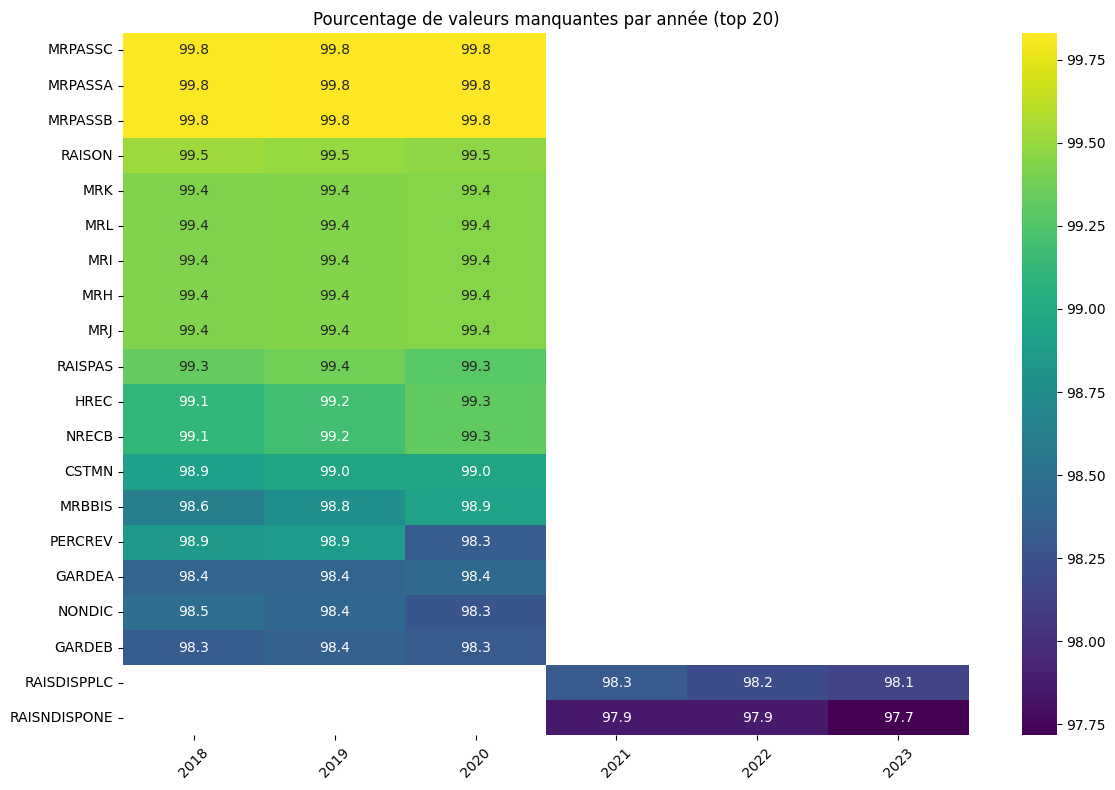

In [12]:
# displaying missing values
plt.figure(figsize=(12, 8))
# first 20 columns with most missing values
missing_top20 = missing_df_sorted.head(20)
sns.heatmap(missing_top20.drop('Moyenne', axis=1), cmap='viridis', annot=True, fmt='.1f')
plt.title('Pourcentage de valeurs manquantes par année (top 20)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()